## Mock rain gage data

In [1]:
import xarray as xr
import pyart

from pyart_radar_tools import *

In [2]:
ID = 'KDIX'

t_start = '2016-02-25 03:00'
t_end = '2016-02-25 04:00'

paths = data_download(ID, t_start, t_end)

using cached file ...
./tmp/KDIX20160225_025507_V06.gz
using cached file ...
./tmp/KDIX20160225_030041_V06.gz
using cached file ...
./tmp/KDIX20160225_030614_V06.gz
using cached file ...
./tmp/KDIX20160225_031147_V06.gz
using cached file ...
./tmp/KDIX20160225_031715_V06.gz
using cached file ...
./tmp/KDIX20160225_032233_V06.gz
using cached file ...
./tmp/KDIX20160225_032748_V06.gz
using cached file ...
./tmp/KDIX20160225_033320_V06.gz
using cached file ...
./tmp/KDIX20160225_033853_V06.gz
using cached file ...
./tmp/KDIX20160225_034419_V06.gz
using cached file ...
./tmp/KDIX20160225_034938_V06.gz


## Define point

In [3]:
lat = 40.35
lon = -74.64

In [5]:
fields = [
          'r_z',
          'kdp',
          'reflectivity',
          'differential_reflectivity',
          'D0',
          'NW',
          'MU',
         ]
cols = [
        'gate_lon',
        'gate_lat',
        'gate_altitude'
       ]
cols.extend(fields)

## Run
First we need to import the tools from pyart_radar_tools, then we can process all the radar files

In [6]:
def process_radar(path, run_QAQC=True,
                  min_dist_km=5, max_dist_km=250,
                  sw_vel=True, max_time_diff=30):
    radar = pyart.io.read(path)
    radar = extract_low_sweeps(radar)

    # run some QAQC:
    if run_QAQC:
        start_gate = get_gate_index(radar, dist_km=min_dist_km)
        end_gate = get_gate_index(radar, dist_km=max_dist_km)
        QAQC_mask = construct_QAQC_mask(radar, start_gate, end_gate,
                                        sw_vel=sw_vel,
                                        max_time_diff=max_time_diff)

    # get out just the sweeps with differential phase values
    radar = extract_field_sweeps(radar, field='differential_phase')
    radar = calculate_dsd_parameters(radar)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)
    if run_QAQC:
        for field in fields:
            radar = interpolate_radially(radar, field, QAQC_mask,
                                         start_gate, end_gate)
    return radar

In [7]:
%%time
radar0 = pyart.io.read(paths[0])
x_disp, y_disp = find_x_y_displacement(radar0, lon, lat)

sweep_times = []
sweep_stacks = []
for path in paths:
    print('processing', path)
    radar = process_radar(path)

    for sweep in range(radar.nsweeps):
        end_sweep_time = get_end_sweep_time(radar, sweep)
        sweep_times.append(end_sweep_time)
        gate_x, gate_y, gate_z = radar.get_gate_x_y_z(sweep)

        distances = np.sqrt((gate_x-x_disp)**2. + 
                            (gate_y-y_disp)**2.)
        ray, gate = np.unravel_index(distances.argmin(), distances.shape)

        a = np.array([radar.gate_latitude['data'][ray, gate],
                      radar.gate_longitude['data'][ray, gate],
                      radar.gate_altitude['data'][ray, gate]])
        a = np.concatenate([a, [radar.fields[field]['data'][ray, gate] for field in fields]])

        sweep_stacks.append(a)
c = np.stack(sweep_stacks, axis=1)

('processing', './tmp/KDIX20160225_025507_V06.gz')
('processing', './tmp/KDIX20160225_030041_V06.gz')
('processing', './tmp/KDIX20160225_030614_V06.gz')
('processing', './tmp/KDIX20160225_031147_V06.gz')
('processing', './tmp/KDIX20160225_031715_V06.gz')
('processing', './tmp/KDIX20160225_032233_V06.gz')
('processing', './tmp/KDIX20160225_032748_V06.gz')
('processing', './tmp/KDIX20160225_033320_V06.gz')
('processing', './tmp/KDIX20160225_033853_V06.gz')
('processing', './tmp/KDIX20160225_034419_V06.gz')
('processing', './tmp/KDIX20160225_034938_V06.gz')
CPU times: user 1min 36s, sys: 6.73 s, total: 1min 43s
Wall time: 1min 43s


In [8]:
d = {'time': {'dims': ('time'), 'data': sweep_times}}
for i, name in enumerate(cols):
    d.update({name: {'dims': ('time'), 'data': c[i]}})
ds_radar = xr.Dataset.from_dict(d)
ds_radar.set_coords(['gate_altitude', 'gate_lat', 'gate_lon'], inplace=True)

<xarray.Dataset>
Dimensions:                    (time: 22)
Coordinates:
    gate_altitude              (time) float64 584.5 708.6 584.5 659.4 621.9 ...
    gate_lat                   (time) float64 -74.64 -74.52 -74.64 -74.58 ...
  * time                       (time) datetime64[ns] 2016-02-25T02:55:25.048000 ...
    gate_lon                   (time) float64 40.35 39.52 40.35 39.53 40.35 ...
Data variables:
    r_z                        (time) float64 0.08809 0.0 0.09564 0.0 0.4202 ...
    reflectivity               (time) float64 10.0 0.0 10.5 0.0 19.5 0.0 5.5 ...
    MU                         (time) float64 3.0 0.0 3.0 0.0 3.0 0.0 3.0 ...
    differential_reflectivity  (time) float64 0.0625 0.0 -0.0625 0.0 -0.125 ...
    kdp                        (time) float64 0.0 0.0 0.05028 0.0 0.2653 0.0 ...
    D0                         (time) float64 0.9116 0.0 0.8547 0.0 0.8341 ...
    NW                         (time) float64 2.595 0.0 2.854 0.0 3.833 0.0 ...

In [13]:
ds_radar.to_netcdf('../PyDisdrometer/Notebooks/radar_output.nc')

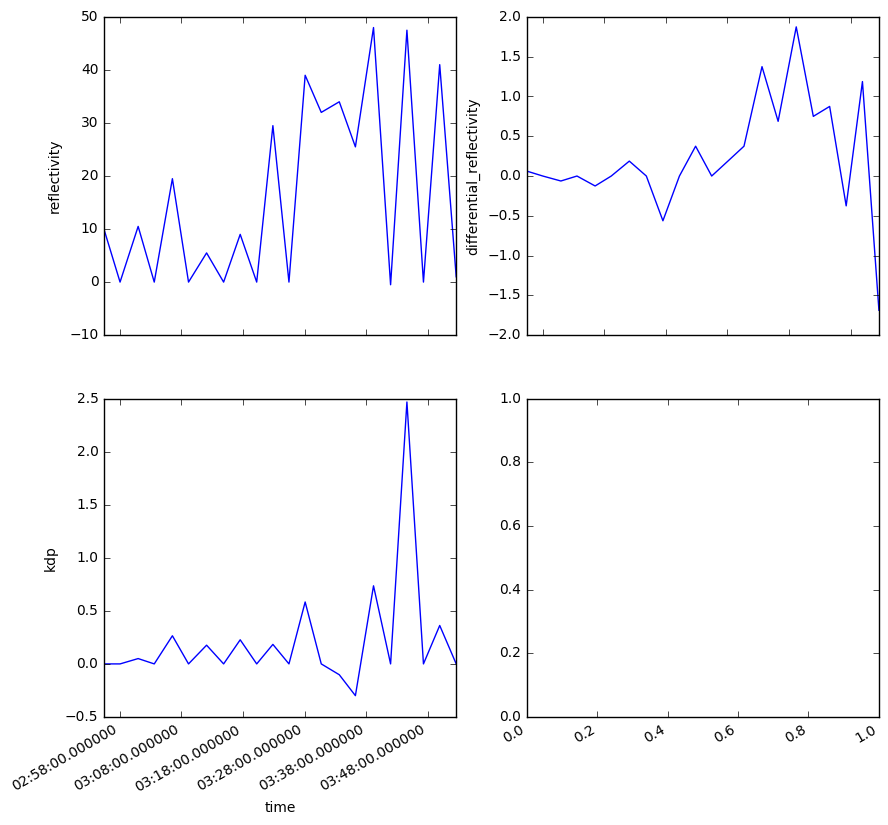

In [12]:
import matplotlib.pyplot as plt

fig, [[ax0, ax1],[ax2, ax3]] = plt.subplots(2, 2, figsize=(10,10))

ds_radar.reflectivity.plot(ax=ax0)
ds_radar.differential_reflectivity.plot(ax=ax1)
ds_radar.kdp.plot(ax=ax2)
ds_radar.D0.plot(ax=ax3)

plt.gcf().autofmt_xdate()

plt.show()